In [1]:
import qiskit 
print(qiskit.__version__)

1.3.1


## Max Cut

In [30]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# quantum imports
from qiskit_optimization.applications import Maxcut
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method='automatic')


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

### Generate a Random Graph

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_1*x_5 - 2*x_2*x_3
  - 2*x_2*x_4 - 2*x_3*x_5 - 2*x_4*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



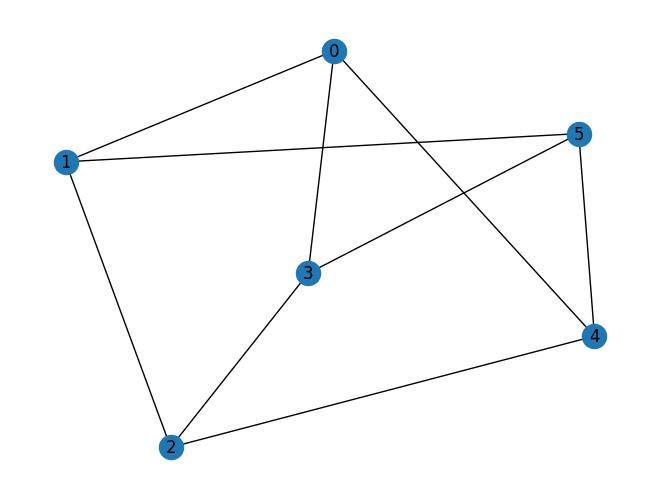

In [26]:
seed = 1
num_nodes = 6
graph = nx.random_regular_graph(d=3, n=num_nodes, seed=seed)
nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph, seed=seed))
# Assign random weights to the edges

maxcut = Maxcut(graph)
problem = maxcut.to_quadratic_program()
print(problem.prettyprint())

### Exact Solution

In [28]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(problem)
print(result.prettyprint())

objective function value: 9.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=1.0, x_5=0.0
status: SUCCESS


In [6]:
# problem to qubo
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Minimize
 obj: - 3 x_0 - 3 x_1 - 3 x_2 - 3 x_3 - 3 x_4 - 3 x_5 + [ 4 x_0*x_1 + 4 x_0*x_3
      + 4 x_0*x_4 + 4 x_1*x_2 + 4 x_1*x_5 + 4 x_2*x_3 + 4 x_2*x_4 + 4 x_3*x_5
      + 4 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



In [7]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -4.5
Ising Hamiltonian:
SparsePauliOp(['IIIIZZ', 'IIZIIZ', 'IZIIIZ', 'IIIZZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIZIII', 'ZZIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


### VQE

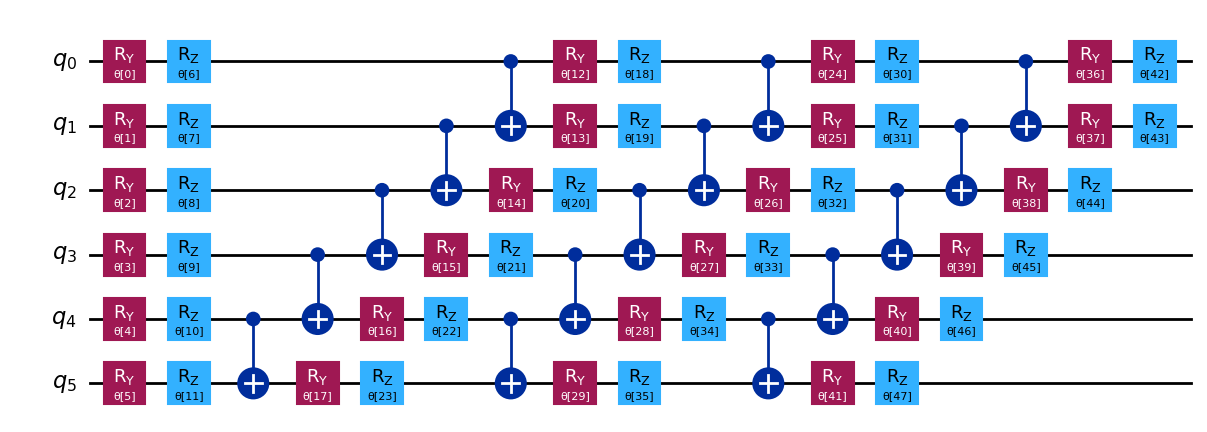

In [9]:
ansatz = EfficientSU2(qubitOp.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [10]:
num_params = ansatz.num_parameters
num_params

48

### Execute

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [12]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [14]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([0.13523894, 3.3335476 , 4.5752841 , 2.0580051 , 4.41497558,
       3.97588001, 3.51367842, 5.54501197, 2.99614309, 1.10127959,
       5.03228675, 2.14424459, 0.96537749, 3.02066895, 1.74819977,
       0.48373159, 5.64795319, 2.30064919, 5.97894665, 6.043842  ,
       4.63892087, 2.72223797, 3.12640791, 3.84664709, 1.23733344,
       3.48007123, 3.89689532, 5.51578028, 1.66080726, 1.33538147,
       0.69702423, 2.44096844, 5.87415592, 2.82086178, 1.23558731,
       2.10795847, 4.63663168, 0.38167007, 0.50748066, 3.98980634,
       5.19578041, 0.78268067, 2.47407659, 0.7822374 , 3.77473303,
       0.77131226, 1.29989684, 3.16482302])

In [18]:
ansatz = ansatz.decompose()

res = minimize(
        cost_func,
        x0,
        args=(ansatz, qubitOp, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.021728515625]
Iters. done: 2 [Current cost: 0.01611328125]
Iters. done: 3 [Current cost: -0.17236328125]
Iters. done: 4 [Current cost: -0.1572265625]
Iters. done: 5 [Current cost: -0.044921875]
Iters. done: 6 [Current cost: -0.327392578125]
Iters. done: 7 [Current cost: -0.30810546875]
Iters. done: 8 [Current cost: -0.263427734375]
Iters. done: 9 [Current cost: -0.351806640625]
Iters. done: 10 [Current cost: -0.207763671875]
Iters. done: 11 [Current cost: -0.29931640625]
Iters. done: 12 [Current cost: -0.277099609375]
Iters. done: 13 [Current cost: -0.1455078125]
Iters. done: 14 [Current cost: -0.0361328125]
Iters. done: 15 [Current cost: -0.31298828125]
Iters. done: 16 [Current cost: -0.31298828125]
Iters. done: 17 [Current cost: -0.23779296875]
Iters. done: 18 [Current cost: -0.384033203125]
Iters. done: 19 [Current cost: -0.595947265625]
Iters. done: 20 [Current cost: -0.57080078125]
Iters. done: 21 [Current cost: -0.658935546875]
Iters. done: 22 [Cu

In [19]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.31982421875
       x: [ 2.529e-02  4.533e+00 ...  1.542e+00  3.747e+00]
    nfev: 639
   maxcv: 0.0

### Post Processing

In [20]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [21]:
cost_history_dict["iters"] == res.nfev

True

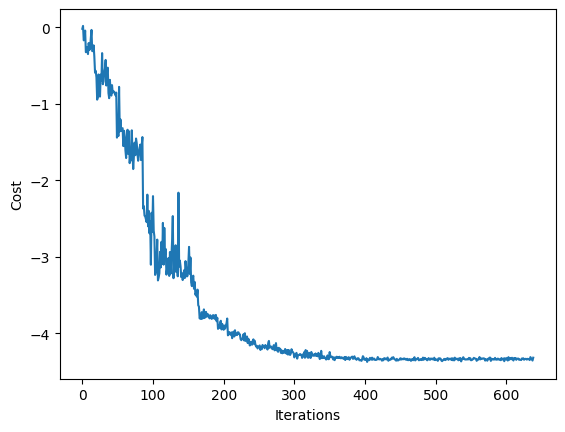

In [22]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

### Run the Optimizer Params

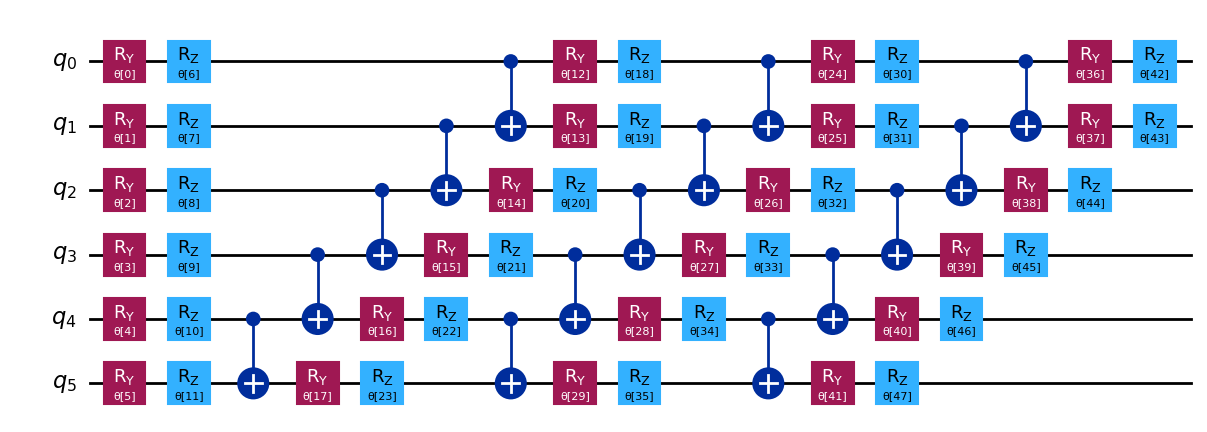

In [23]:
ansatz.draw("mpl", style="iqp")

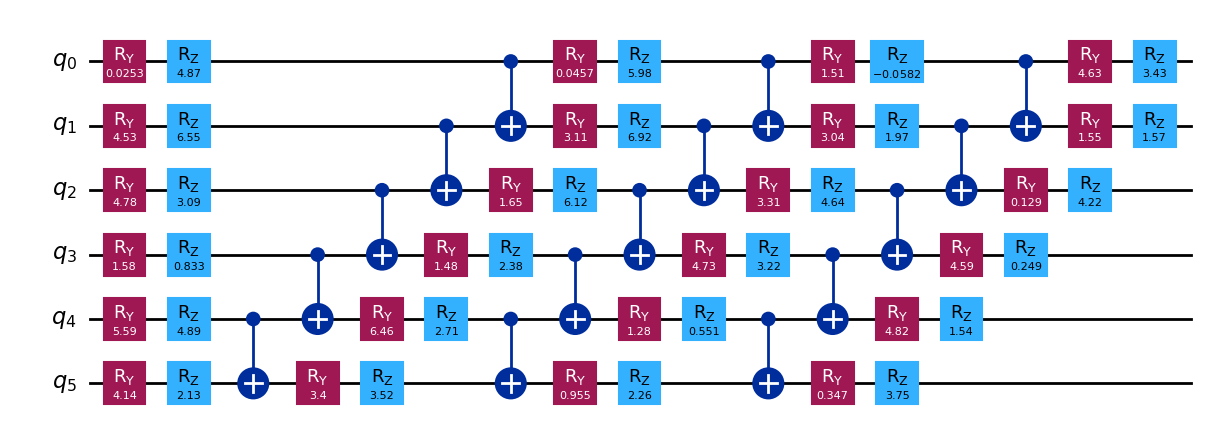

In [24]:
ansatz = ansatz.assign_parameters(res.x)
ansatz.draw("mpl", style="iqp")

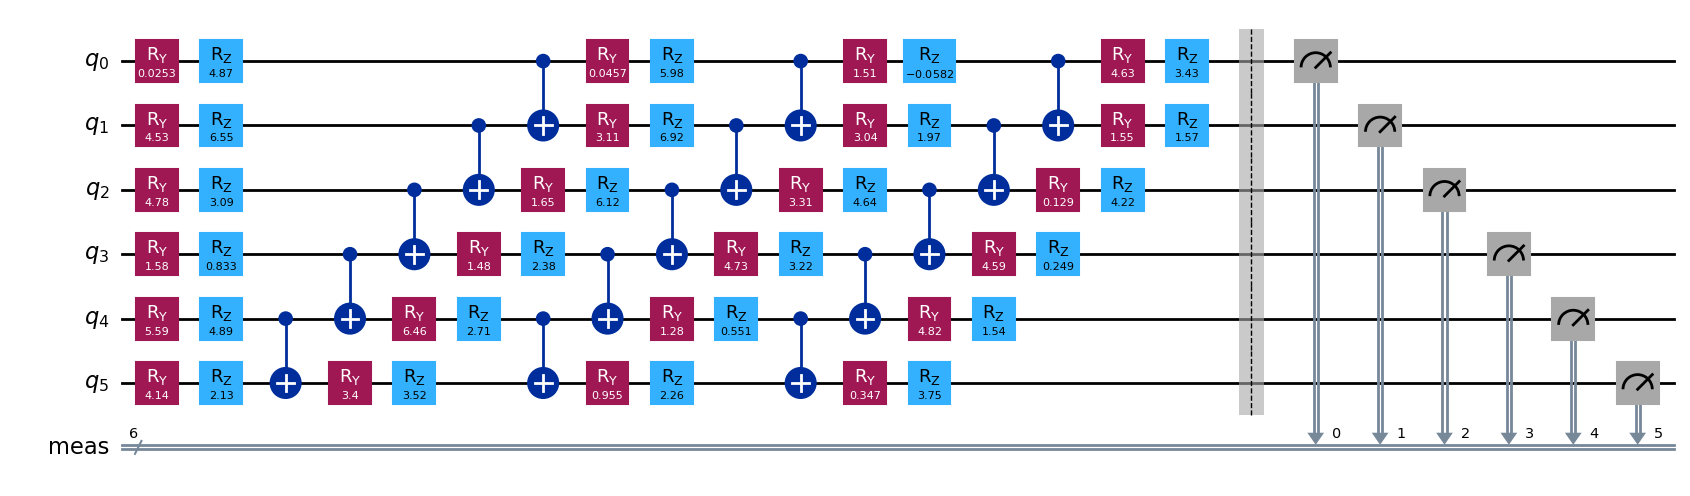

In [29]:
ansatz.measure_all()
ansatz.draw("mpl", style="iqp")

In [31]:
pub = (ansatz,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [33]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_nodes)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 0, 1, 1, 0]


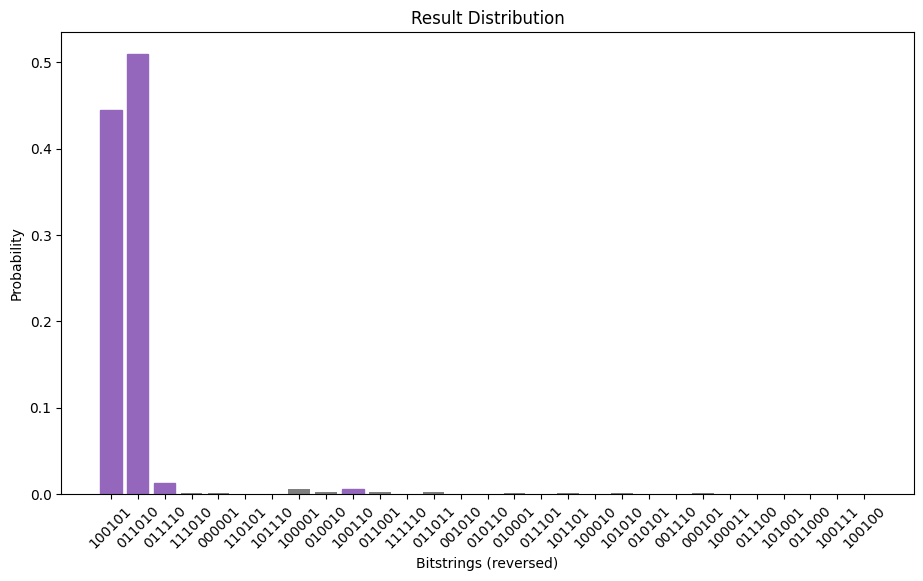

In [34]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin  # Assuming final_distribution_bin is defined elsewhere
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.extend(np.where(values == value)[0].tolist())  # Extract as a list to get individual elements

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")

# Ensure each position is an integer index for setting color
for p in positions:
    ax.get_children()[p].set_color("tab:purple")

plt.show()